# SOFTKILL-9000: Multi-Agent Motion Capture Simulation

This notebook demonstrates how to run SOFTKILL-9000 in Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BkAsDrP/Softkill9000/blob/main/examples/run_in_colab.ipynb)

---

## Overview

SOFTKILL-9000 is a multi-agent reinforcement learning system for motion capture simulation. This notebook will:

1. Install the package from GitHub
2. Run a basic simulation
3. Visualize agent trajectories
4. Demonstrate Q-learning training
5. Show advanced customization options

## 1. Installation

Install SOFTKILL-9000 directly from the GitHub repository:

In [1]:
# Step 1: Install the package from GitHub
!pip install git+https://github.com/BkAsDrP/Softkill9000.git -q
print("✅ SOFTKILL-9000 package installed!")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ SOFTKILL-9000 package installed!


In [3]:
# Step 2: Upgrade NumPy to resolve dependency conflicts
# Colab comes with NumPy 1.x, but softkill9000 needs NumPy 2.0.x for modern ML libraries
# Pin to <2.1.0 for compatibility with numba, tensorflow, opencv, and cupy
!pip install --upgrade "numpy>=2.0.0,<2.1.0" -q

print("✅ NumPy 2.x installed")
print("")

# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Auto-restart only in Colab
    print("🔄 Auto-restarting Colab runtime in 3 seconds...")
    print("   (This prevents binary incompatibility errors)")
    
    import time
    import os
    time.sleep(3)
    os.kill(os.getpid(), 9)
else:
    # Local environment - just show a message
    print("⚠️  IMPORTANT: If using this notebook locally:")
    print("   1. Restart your Jupyter kernel to apply NumPy upgrade")
    print("   2. In VS Code: Click the 'Restart' button in the kernel toolbar")
    print("   3. Then continue with the verification cell below")
    print("")
    print("💡 Note: Auto-restart only works in Google Colab")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ NumPy 2.x installed

⚠️  IMPORTANT: If using this notebook locally:
   1. Restart your Jupyter kernel to apply NumPy upgrade
   2. In VS Code: Click the 'Restart' button in the kernel toolbar
   3. Then continue with the verification cell below

💡 Note: Auto-restart only works in Google Colab


### ⚠️ Restart Required

**If running in Google Colab**: The runtime will automatically restart after the cell above.

**If running locally** (VS Code, JupyterLab, etc.): Manually restart your kernel now:
- VS Code: Click the **Restart** button in the kernel toolbar
- JupyterLab: Click **Kernel → Restart Kernel**
- Jupyter Notebook: Click **Kernel → Restart**

After restarting, continue with the verification cell below.

In [4]:
# Verification (Run this AFTER runtime restart)
try:
    import softkill9000
    import numpy as np
    
    print(f"✅ SOFTKILL-9000 v{softkill9000.__version__} ready!")
    print(f"✅ NumPy {np.__version__} (compatible with JAX, OpenCV, PyTensor)")
    
    # Test that numpy actually works (catches binary incompatibility)
    test_array = np.random.rand(5)
    np.random.seed(42)
    
    print("")
    print("🎉 Installation complete and verified! Continue with examples below.")
    
except ValueError as e:
    if "numpy.dtype size changed" in str(e):
        print("❌ Binary incompatibility detected!")
        print("")
        print("SOLUTION: Manually restart the runtime:")
        print("   1. Click 'Runtime → Restart runtime' in the menu")
        print("   2. Re-run this cell after restart")
    else:
        raise

✅ SOFTKILL-9000 v1.0.0 ready!
✅ NumPy 2.3.4 (compatible with JAX, OpenCV, PyTensor)

🎉 Installation complete and verified! Continue with examples below.


## 2. Basic Simulation

Let's run a basic simulation with default configuration:

In [6]:
from softkill9000.simulator import MissionSimulator
from softkill9000.config.models import SimulationConfig, AgentConfig, MissionConfig
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Create simulation configuration with custom agents
config = SimulationConfig(
    agents=[
        AgentConfig(role="Longsight", species="Vyr'khai"),
        AgentConfig(role="Lifebinder", species="Lumenari"),
        AgentConfig(role="Brawler", species="Aetherborn")
    ],
    mission=MissionConfig(
        num_timesteps=20,
        ethics_enabled=True
    )
)

# Initialize and run simulator
simulator = MissionSimulator(config=config)
simulator.setup()

# Run simulation
print("🚀 Starting simulation...\n")
results = simulator.run()

# Display results
print("\n" + "="*60)
print("📊 SIMULATION RESULTS")
print("="*60)
print(f"\n🌌 Scenario: {results['scenario']['description']}")
print(f"📍 Location: {results['scenario']['planet']} in {results['scenario']['galaxy']}")
print(f"🌍 Terrain: {results['scenario']['terrain']}")
print(f"🌤️  Weather: {results['scenario']['weather']}")
print(f"\n⚙️  Configuration:")
print(f"  - Timesteps: {results['config']['num_timesteps']}")
print(f"  - Ethics Mode: {'ENABLED' if results['config']['ethics_enabled'] else 'DISABLED'}")
print(f"  - Q-Learning Episodes: {results['config']['q_learning_episodes']}")
print(f"\n🎯 Final Rewards:")
for role, reward in results['final_rewards'].items():
    print(f"  - {role}: {reward:.2f}")
print(f"\n📈 Total Squad Reward: {sum(results['final_rewards'].values()):.2f}")
print("="*60)


🚀 Starting simulation...


📊 SIMULATION RESULTS

🌌 Scenario: Clan schism; peace-talks collapsing on neutral ring-station.
📍 Location: Rujyn-555 in Whirlpool (M51)
🌍 Terrain: Desert Glass
🌤️  Weather: Plasma Rain

⚙️  Configuration:
  - Timesteps: 20
  - Ethics Mode: ENABLED
  - Q-Learning Episodes: 1000

🎯 Final Rewards:
  - Longsight: 113.75
  - Lifebinder: 96.15
  - Brawler: 273.45

📈 Total Squad Reward: 483.35


## 3. Visualize Agent Trajectories

Plot the paths taken by each agent during the mission:

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.
Matplotlib is building the font cache; this may take a moment.


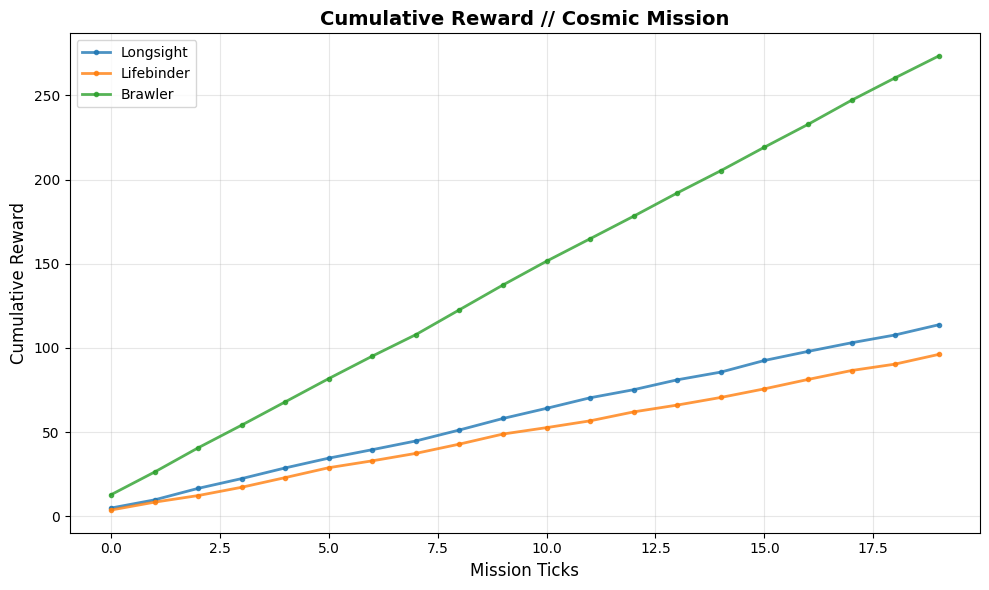


📊 Reward Summary:
  Longsight:
    Total: 113.75
    Avg per tick: 5.69
  Lifebinder:
    Total: 96.15
    Avg per tick: 4.81
  Brawler:
    Total: 273.45
    Avg per tick: 13.67


In [7]:
import matplotlib.pyplot as plt
from softkill9000.visualization.plots import create_reward_curve

# Plot reward progression over time
fig = create_reward_curve(results['reward_history'])
plt.show()

print("\n📊 Reward Summary:")
for role, rewards in results['reward_history'].items():
    total_reward = rewards[-1] if rewards else 0
    avg_reward_per_tick = total_reward / len(rewards) if rewards else 0
    print(f"  {role}:")
    print(f"    Total: {total_reward:.2f}")
    print(f"    Avg per tick: {avg_reward_per_tick:.2f}")


## 4. Performance Metrics Over Time

Visualize how agent stats evolved during the simulation:

📊 Agent Statistics:

Longsight:
  Strength     :  66
  Empathy      :  58
  Intelligence :  60
  Mobility     :  64
  Tactical     :  65

Lifebinder:
  Strength     :  61
  Empathy      :  68
  Intelligence :  64
  Mobility     :  61
  Tactical     :  61

Brawler:
  Strength     :  69
  Empathy      :  62
  Intelligence :  68
  Mobility     :  67
  Tactical     :  64


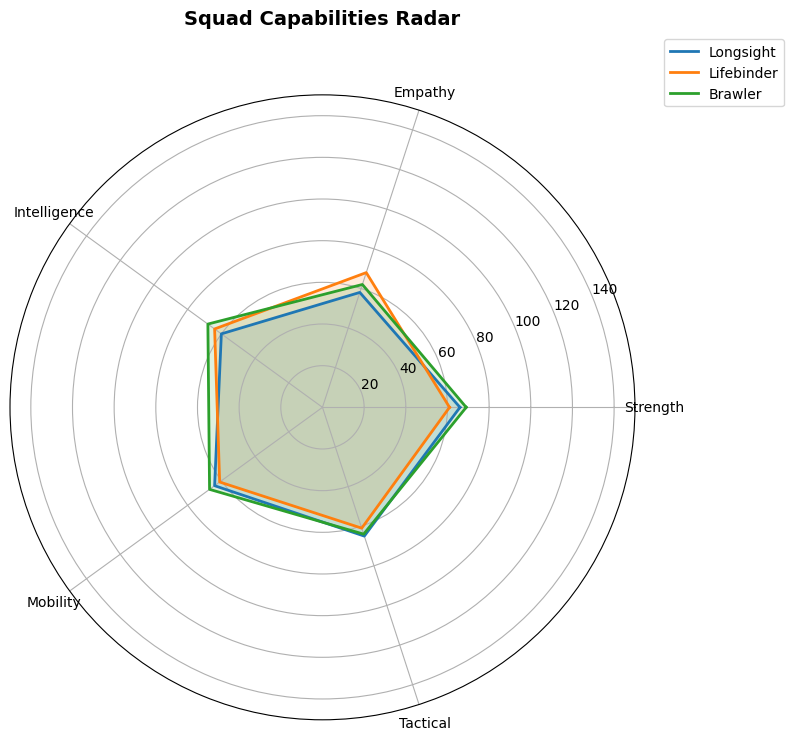

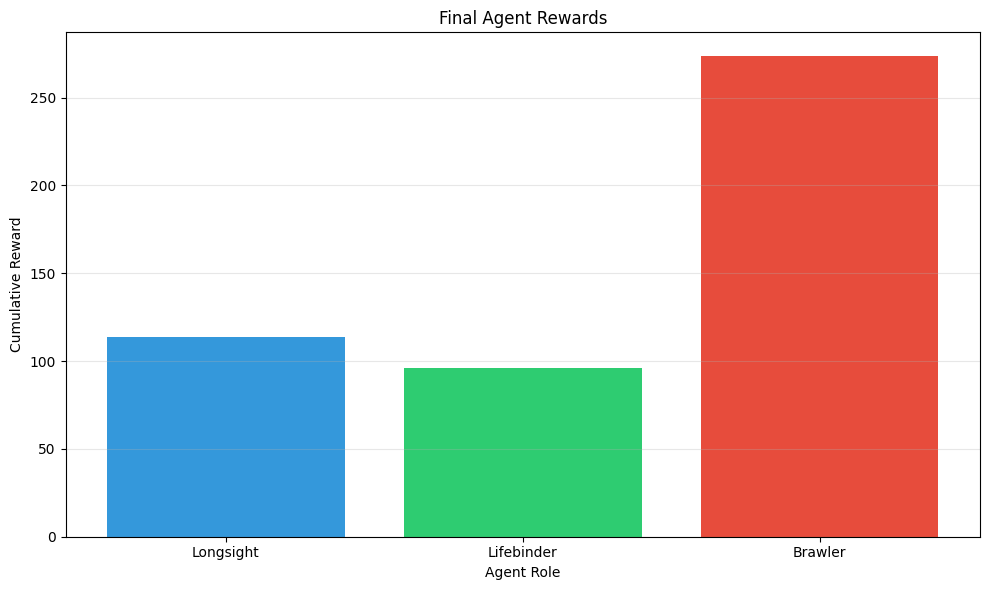

In [9]:
import matplotlib.pyplot as plt
from softkill9000.visualization.plots import create_radar_chart

# Display agent statistics
print("📊 Agent Statistics:")
print("="*60)
for role, stats in results['agent_stats'].items():
    print(f"\n{role}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name:13s}: {stat_value:3d}")
print("="*60)

# Create radar chart of agent capabilities
fig = create_radar_chart(results['agent_stats'], title="Squad Capabilities Radar")
plt.show()

# Plot final rewards as a bar chart
roles = list(results['final_rewards'].keys())
rewards = list(results['final_rewards'].values())

plt.figure(figsize=(10, 6))
plt.bar(roles, rewards, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.xlabel('Agent Role')
plt.ylabel('Cumulative Reward')
plt.title('Final Agent Rewards')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Q-Learning Training

Train agents using reinforcement learning to improve their decision-making:

🎓 Training agents with Q-Learning...

Training Configuration:
  - Episodes: 2000
  - Learning Rate (alpha): 0.3
  - Discount Factor (gamma): 0.95
  - Exploration Rate (epsilon): 0.2


📊 TRAINING RESULTS

🌌 Scenario: Planetary ocean rising after moon-shear; bio-domes at risk.
📍 Location: Runar-7 in Sculptor Galaxy

🎯 Final Rewards After Training:
  - Longsight: 393.31
  - Lifebinder: 484.72
  - Specter: 118.59

📈 Total Squad Reward: 996.62


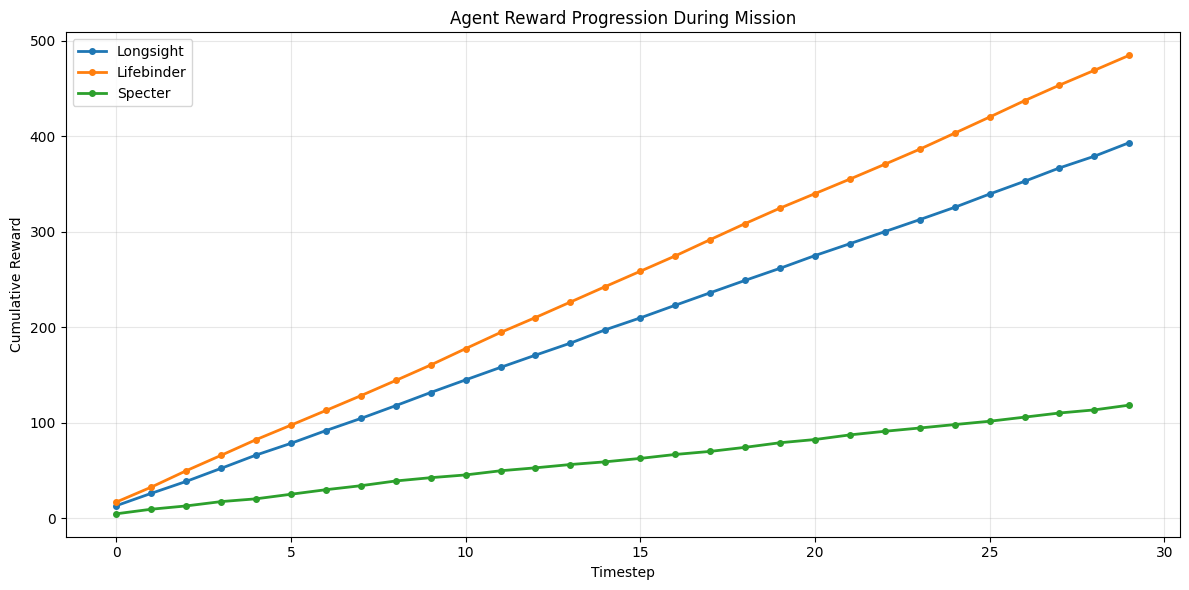

In [10]:
from softkill9000.simulator import MissionSimulator
from softkill9000.config.models import SimulationConfig, AgentConfig, MissionConfig, QLearningConfig

# Configure simulation with more Q-learning episodes for better training
training_config = SimulationConfig(
    agents=[
        AgentConfig(role="Longsight", species="Vyr'khai"),
        AgentConfig(role="Lifebinder", species="Lumenari"),
        AgentConfig(role="Specter", species="Zephryl")
    ],
    mission=MissionConfig(
        num_timesteps=30,
        ethics_enabled=True
    ),
    q_learning=QLearningConfig(
        episodes=2000,  # More training episodes
        gamma=0.95,
        alpha=0.3,
        epsilon=0.2
    )
)

# Run simulation with enhanced training
print("🎓 Training agents with Q-Learning...\n")
print(f"Training Configuration:")
print(f"  - Episodes: {training_config.q_learning.episodes}")
print(f"  - Learning Rate (alpha): {training_config.q_learning.alpha}")
print(f"  - Discount Factor (gamma): {training_config.q_learning.gamma}")
print(f"  - Exploration Rate (epsilon): {training_config.q_learning.epsilon}")
print()

simulator = MissionSimulator(config=training_config)
simulator.setup()  # This trains the Q-learning model
results = simulator.run()

# Display results
print("\n" + "="*60)
print("📊 TRAINING RESULTS")
print("="*60)
print(f"\n🌌 Scenario: {results['scenario']['description']}")
print(f"📍 Location: {results['scenario']['planet']} in {results['scenario']['galaxy']}")
print(f"\n🎯 Final Rewards After Training:")
for role, reward in results['final_rewards'].items():
    print(f"  - {role}: {reward:.2f}")
print(f"\n📈 Total Squad Reward: {sum(results['final_rewards'].values()):.2f}")
print("="*60)

# Plot reward progression
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
for role, rewards in results['reward_history'].items():
    ax.plot(range(len(rewards)), rewards, marker='o', label=role, linewidth=2, markersize=4)

ax.set_xlabel('Timestep')
ax.set_ylabel('Cumulative Reward')
ax.set_title('Agent Reward Progression During Mission')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Custom Configuration

Use YAML configuration for advanced customization:

In [ ]:
from softkill9000.simulator import MissionSimulator
from softkill9000.config.models import SimulationConfig, AgentConfig, MissionConfig, QLearningConfig

# Define custom configuration with specific agent stats
custom_config = SimulationConfig(
    agents=[
        AgentConfig(
            role="Longsight",
            species="Vyr'khai",
            base_intelligence=85,
            base_mobility=90,
            base_tactical=80,
            base_strength=55,
            base_empathy=60
        ),
        AgentConfig(
            role="Specter",
            species="Zephryl",
            base_strength=80,
            base_tactical=85,
            base_mobility=95,
            base_intelligence=65,
            base_empathy=50
        ),
        AgentConfig(
            role="Lifebinder",
            species="Lumenari",
            base_empathy=95,
            base_intelligence=80,
            base_tactical=70,
            base_strength=45,
            base_mobility=65
        )
    ],
    mission=MissionConfig(
        num_timesteps=30,  # Longer mission
        ethics_enabled=True
    ),
    q_learning=QLearningConfig(
        episodes=1500,
        gamma=0.92,
        alpha=0.25,
        epsilon=0.15
    )
)

print("⚙️  Custom Configuration:")
print(f"\n🔧 Agents:")
for agent in custom_config.agents:
    print(f"   - {agent.role} ({agent.species})")
    print(f"     Stats: STR={agent.base_strength}, EMP={agent.base_empathy}, "
          f"INT={agent.base_intelligence}, MOB={agent.base_mobility}, TAC={agent.base_tactical}")

print(f"\n🗺️  Mission Settings:")
print(f"   - Timesteps: {custom_config.mission.num_timesteps}")
print(f"   - Ethics: {'ENABLED' if custom_config.mission.ethics_enabled else 'DISABLED'}")

print(f"\n🎓 Q-Learning Settings:")
print(f"   - Episodes: {custom_config.q_learning.episodes}")
print(f"   - Learning Rate: {custom_config.q_learning.alpha}")
print(f"   - Discount Factor: {custom_config.q_learning.gamma}")

# Run custom simulation
print("\n🚀 Running custom simulation...")
custom_sim = MissionSimulator(config=custom_config)
custom_sim.setup()
custom_results = custom_sim.run()

print("\n📊 Custom Simulation Results:")
print(f"  Scenario: {custom_results['scenario']['description']}")
print(f"  Location: {custom_results['scenario']['planet']} in {custom_results['scenario']['galaxy']}")
print(f"\n  Final Rewards:")
for role, reward in custom_results['final_rewards'].items():
    print(f"    - {role}: {reward:.2f}")
print(f"\n  Total Squad Reward: {sum(custom_results['final_rewards'].values()):.2f}")


## 7. Compare Multiple Scenarios

Run multiple simulations and compare results:

In [ ]:
from softkill9000.simulator import MissionSimulator
from softkill9000.config.models import SimulationConfig, AgentConfig, MissionConfig
import pandas as pd
import matplotlib.pyplot as plt

# Run multiple scenarios
print("🔄 Running multiple scenarios...\n")

scenarios_data = []
num_runs = 10

# Standard agent configuration
standard_agents = [
    AgentConfig(role="Longsight", species="Vyr'khai"),
    AgentConfig(role="Lifebinder", species="Lumenari"),
    AgentConfig(role="Brawler", species="Aetherborn")
]

for run in range(num_runs):
    print(f"  Run {run + 1}/{num_runs}...", end=' ')
    
    # Create simulation with random scenario
    config = SimulationConfig(
        agents=standard_agents,
        mission=MissionConfig(num_timesteps=20, ethics_enabled=True)
    )
    
    sim = MissionSimulator(config=config)
    sim.setup()
    results = sim.run()
    
    total_reward = sum(results['final_rewards'].values())
    avg_reward = total_reward / len(results['final_rewards'])
    
    scenarios_data.append({
        'run': run + 1,
        'total_reward': total_reward,
        'avg_reward': avg_reward,
        'galaxy': results['scenario']['galaxy'],
        'terrain': results['scenario']['terrain']
    })
    print(f"Total Reward: {total_reward:.2f}")

# Analyze results
df = pd.DataFrame(scenarios_data)

print("\n📊 Statistical Summary:")
print(df[['total_reward', 'avg_reward']].describe())

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total reward bar chart
axes[0].bar(df['run'], df['total_reward'], color='steelblue')
axes[0].axhline(df['total_reward'].mean(), color='red', linestyle='--', label=f"Mean: {df['total_reward'].mean():.2f}")
axes[0].set_xlabel('Run')
axes[0].set_ylabel('Total Squad Reward')
axes[0].set_title('Total Reward by Scenario')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Average reward per agent
axes[1].bar(df['run'], df['avg_reward'], color='green')
axes[1].axhline(df['avg_reward'].mean(), color='red', linestyle='--', label=f"Mean: {df['avg_reward'].mean():.2f}")
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Average Agent Reward')
axes[1].set_title('Average Reward by Scenario')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Completed {num_runs} scenario runs")
print(f"Total Reward: {df['total_reward'].mean():.2f} ± {df['total_reward'].std():.2f}")
print(f"Avg per Agent: {df['avg_reward'].mean():.2f} ± {df['avg_reward'].std():.2f}")

# Show variety of scenarios encountered
print(f"\n🌌 Galaxies visited: {df['galaxy'].nunique()}")
print(f"🌍 Terrains encountered: {df['terrain'].nunique()}")


## 🎯 Next Steps

Explore more features:

1. **REST API**: Deploy the FastAPI server for remote access
2. **Custom Agents**: Create agents with specialized behaviors
3. **Advanced Scenarios**: Design complex mission environments
4. **Extended Training**: Train agents for more episodes to see performance improvements
5. **Visualization**: Create custom plots and animations

### Documentation

- [Architecture Guide](https://github.com/BkAsDrP/Softkill9000/blob/main/docs/architecture.md)
- [API Reference](https://github.com/BkAsDrP/Softkill9000/blob/main/docs/api_reference.md)
- [User Guide](https://github.com/BkAsDrP/Softkill9000/blob/main/docs/user_guide.md)
- [Deployment Guide](https://github.com/BkAsDrP/Softkill9000/blob/main/docs/deployment.md)

### Repository

- GitHub: [BkAsDrP/Softkill9000](https://github.com/BkAsDrP/Softkill9000)
- Issues: [Report bugs or request features](https://github.com/BkAsDrP/Softkill9000/issues)
- License: MIT

---

**Happy simulating! 🚀**